In [60]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [61]:
# Set device to gpu if available
import torch
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [62]:
!nvidia-smi

Fri Apr 15 11:28:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    36W / 250W |   1851MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [63]:
# Install required packages
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [64]:
# Import modules
import networkx as nx
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip
from torch_geometric.utils.convert import to_networkx

import tqdm
import time
import sys
import os
import math
import random
import torch.nn.functional as F
import torch.utils.data as data_utils
import numpy as np

import pandas as  pd

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [65]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [66]:
fix_random(42)

## The dataset

In [ ]:
'''
The citation network datasets “Cora”, “CiteSeer” and “PubMed” from the
“Revisiting Semi-Supervised Learning with Graph Embeddings” paper. Nodes
represent documents and edges represent citation links. Training, validation
and test splits are given by binary masks.
'''
from torch_geometric.datasets import Planetoid
# dataset = Planetoid(root="datasets", name="Cora", split="full")
dataset = Planetoid(root="datasets", name="PubMed", split="full")

In [ ]:
'''
The Amazon dataset from the “GraphSAINT: Graph Sampling Based Inductive
Learning Method” paper, containing products and its categories.
'''
# from torch_geometric.datasets import AmazonProducts
# dataset = AmazonProducts(root="datasets")

In [ ]:
'''
The Reddit dataset from the “GraphSAINT: Graph Sampling Based Inductive Learning
Method” paper, containing Reddit posts belonging to different communities.
'''
# from torch_geometric.datasets import Reddit2
# dataset = Reddit2(root="datasets")

In [ ]:
'''
The Flickr dataset from the “GraphSAINT: Graph Sampling Based Inductive Learning
Method” paper, containing descriptions and common properties of images.
'''
# from torch_geometric.datasets import Flickr
# dataset = Flickr(root="datasets")

In [124]:
data = dataset[0]
print(data)

if len(data.y.shape) == 2:
    data.y = torch.argmax(data.y, dim=1)

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


In [125]:
print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 18217
Training node label rate: 0.924
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Let's see if class are balanced or not across the splits:

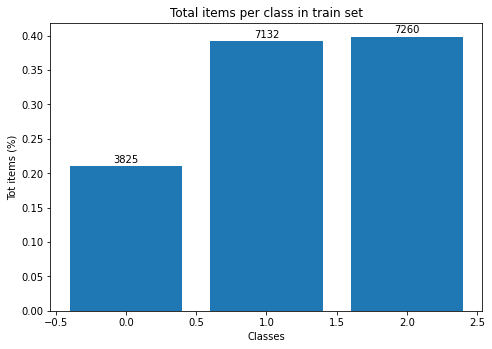

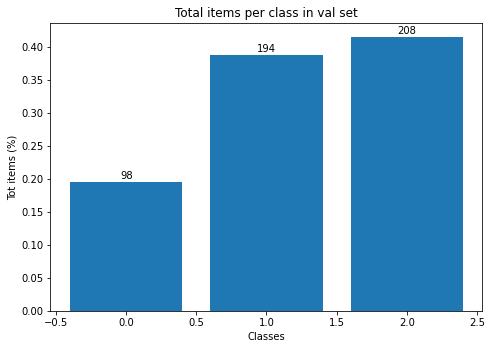

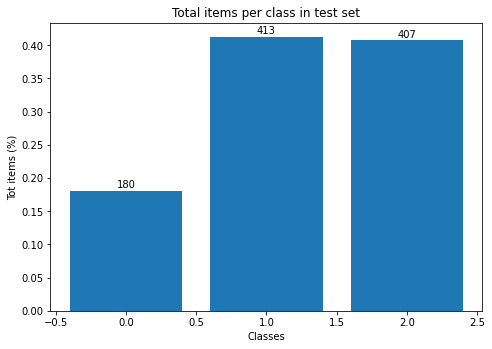

In [126]:
def plot_total_per_class(dataset, split):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    classes = [c for c in range(dataset.num_classes)]
    totals = [0 for c in range(dataset.num_classes)]

    for i in range(len(dataset)):
        graph = dataset[i]
        split_mask = {
        'train' : graph.train_mask,
        'val': graph.val_mask,
        'test': graph.test_mask,
        }
        items = [graph.y[split_mask[split]].tolist().count(i) for i in classes ]
        totals = [x + y for x, y in zip(totals, items)]

    normalized_totals = [float(x) / np.sum(totals) for x in totals]
    bars = ax.bar(classes, normalized_totals)

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + .005, totals[i], ha='center')

    plt.xlabel('Classes')
    plt.ylabel('Tot items (%)')
    plt.title(f"Total items per class in {split} set")
    plt.show()

    return normalized_totals

normalized_totals_train = plot_total_per_class(dataset, 'train')
normalized_totals_val   = plot_total_per_class(dataset, 'val')
normalized_totals_test  = plot_total_per_class(dataset, 'test')

In [127]:
from torch_geometric.loader import NeighborLoader
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[30], #* 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=1024*10,
    input_nodes=data.train_mask,
)

val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[30], #* 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=1024*10,
    input_nodes=data.val_mask,
)

test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[30], #* 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=1024*10,
    input_nodes=data.test_mask,
)

In [128]:
sampled_data = next(iter(train_loader))
print(sampled_data)
print(len(train_loader))
print()
sampled_data = next(iter(val_loader))
print(sampled_data)
print(len(val_loader))
print()
sampled_data = next(iter(test_loader))
print(sampled_data)
print(len(test_loader))

Data(x=[16922, 500], edge_index=[2, 44470], y=[16922], train_mask=[16922], val_mask=[16922], test_mask=[16922], batch_size=10240)
2

Data(x=[2281, 500], edge_index=[2, 2131], y=[2281], train_mask=[2281], val_mask=[2281], test_mask=[2281], batch_size=500)
1

Data(x=[4208, 500], edge_index=[2, 4457], y=[4208], train_mask=[4208], val_mask=[4208], test_mask=[4208], batch_size=1000)
1


# Model Definition

**GATv2**

Popular GNN architectures weigh all neighbors $j \in N_{i}$ with equal importance (e.g., mean or max-pooling as AGGREGATE). To
address this limitation, GAT computes a score
for every edge $(j, i)$, which indicates the importance of the features of the neighbor $j$ to the node $i$.

GAT convolution is matematically defined as:

$$ x_{i}^{'} = \alpha_{i,j} \Theta x_{i} + \sum_{j \in \mathcal{N}(i)} \alpha_{i,j} \Theta x_{j}$$

the scoring function is defined as:

$$ e(x_{i}, x_{j}) =  \text{LeakyReLU}(a^\top \cdot [\Theta x_{i} || \Theta x_{j}]) $$

and is used to compute the attention coefficients:

$$ \alpha_{i,j} = \text{softmax}_{j}(e(x_{i}, x_{j})) =  \frac{\exp(e(x_{i}, x_{j}))}{\sum_{j^{'} \in \mathcal{N}} \exp(e(x_{i}, x_{j^{'}}))} $$


The main problem in the standard GAT scoring function  is that the learned layers $\Theta$ and $a$ are applied consecutively, and thus can be collapsed into a single linear layer. To fix
this limitation, in GATv2 the $a$ layer is applied after the nonlinearity (LeakyReLU), and the $\Theta$ layer
after the concatenation, effectively applying an MLP to compute the score for each query-key pair:

$$ e(x_{i}, x_{j}) =  a^\top \text{LeakyReLU}(\Theta \cdot [x_{i} ||  x_{j}]) $$

In [129]:
from torch_geometric.nn.conv import GATv2Conv
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.norm import BatchNorm

class ParametrizedGATNet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop=0.5, n_layers=2, n_heads=3, skip_conn=False, post_proc_MLP=False):
        super(ParametrizedGATNet, self).__init__()
        self.p_drop = p_drop
        self.skip_conn = skip_conn

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(1, n_layers):
            conv = GATv2Conv(in_dim, hid_dim, heads=n_heads, concat=True)
            in_dim = hid_dim * n_heads
            bn = BatchNorm(in_dim)
            self.convs.append(conv)
            self.bns.append(bn)
            
        conv = GATv2Conv(in_dim, out_dim, heads=1, concat=False)
        bn = BatchNorm(out_dim)
        self.convs.append(conv)
        self.bns.append(bn)

        self.post_proc_MLP = post_proc_MLP
        self.MLPs = torch.nn.ModuleList()
        if post_proc_MLP:
            self.MLPs.append(Linear(out_dim, hid_dim))
            self.MLPs.append(Linear(hid_dim, hid_dim))
            self.MLPs.append(Linear(hid_dim, out_dim))


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        x_prev = None
        for i, (conv, bn) in enumerate(zip(self.convs[:-1], self.bns[:-1])):
            x = conv(x, edge_index)
            x = bn(x)

            if self.skip_conn and x_prev is not None:
                x = torch.add(x, x_prev)
            
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x_prev = x
        
        x = self.convs[-1](x, edge_index)
        x = self.bns[-1](x)

        if self.post_proc_MLP:
            for i, mlp in enumerate(self.MLPs):
                x = F.relu(mlp(x))
        
        h = F.log_softmax(x, dim=1)
        return h

# Train and evaluate DL models

The train function performs 10 trials resetting each time the model weights and running a training for 100 epochs, after each epoch a validation phase is performed. The metric used is the accuracy since the problem has balanced classes.

Early stopping is performed in order to prevent the model to overfit on train set, in particular, if the accuracy on validation set get worse cosecutively for more time than the patience the train is aborted.

The train funcion returns the weights of the best model alongside its corresponding history and embeddings.

The test function performs the evaluation of the model in terms of accuracy.

In [130]:
def train(model, optimizer, loss_fn, trials=1, epochs=20, patience=5, device='cuda', verbose=2):

    if verbose > 1: print('Train: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    start_time_sec = time.time()

    best_model_weights = None
    best_model_history = None

    best_val_acc = 0

    model.to(device)

    for trial in range(trials):
        if verbose > 1: print(f'Trial n°{trial+1}:')
        model.reset_parameters()

        trigger_times = 0
        last_val_acc = 0

        history = {}
        history['loss'] = []
        history['val_loss'] = []
        history['acc'] = []
        history['val_acc'] = []

        embeddings = []

        
        iterator = tqdm.tqdm(range(epochs), desc = f'Trial n°{trial+1}') if verbose < 2 else range(epochs)
        for epoch in iterator:

            # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
            model.train()
            num_train_correct  = 0
            num_train_examples = 0

            for batch in train_loader:
                batch.to(device)
                train_loss_item = 0.0
                optimizer.zero_grad()

                yhat = model(batch.x, batch.edge_index)
                train_loss = loss_fn(yhat[batch.train_mask], batch.y[batch.train_mask])
                train_loss_item = train_loss.item()

                train_loss.backward()
                optimizer.step()

                num_train_correct  += (torch.max(yhat[batch.train_mask], 1)[1] == batch.y[batch.train_mask]).sum().item()
                num_train_examples += batch.y[batch.train_mask].shape[0]
            train_acc   = num_train_correct / num_train_examples

            embeddings.append(yhat)

            # --- EVALUATE ON VALIDATION SET -------------------------------------
            model.eval()
            num_val_correct  = 0
            num_val_examples = 0
            val_acc = 0

            with torch.no_grad():
                for batch in val_loader:
                    batch.to(device)
                    val_loss_item = 0.0
                
                    yhat = model(batch.x, batch.edge_index)
                    val_loss = loss_fn(yhat[batch.val_mask], batch.y[batch.val_mask])
                    val_loss_item = val_loss.item()
                
                    # Evaluation method that takes into account problem of unbalanced class by weighting the score based on percentage of each class on the total
                    num_val_examples += batch.y[batch.val_mask].shape[0]
                    for label_class in range(dataset.num_classes):
                        num_val_correct = ((torch.max(yhat[batch.val_mask], 1)[1] == label_class) & (torch.max(yhat[batch.val_mask], 1)[1] == batch.y[batch.val_mask])).sum().item()
                        num_val_examples =  (batch.y[batch.val_mask] == label_class).sum().item()
                        val_acc += num_val_correct / num_val_examples * normalized_totals_val[label_class]
                val_acc = val_acc / len(val_loader)

                    # Classic evaluation method of accuracy
                #     num_val_correct  += (torch.max(yhat[batch.val_mask], 1)[1] == batch.y[batch.val_mask]).sum().item()
                #     num_val_examples += batch.y[batch.val_mask].shape[0]
                # val_acc  = num_val_correct / num_val_examples

            if verbose > 1 and ( (epoch + 1) % 10 == 0 or epoch == 0 ) :
                print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch+1, epochs, train_loss_item, train_acc, val_loss_item, val_acc))

            history['loss'].append(train_loss_item)
            history['val_loss'].append(val_loss_item)
            history['acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            

            # Early stopping
            if history['val_acc'][-1] < last_val_acc:
                trigger_times += 1
                if trigger_times >= patience:
                    if verbose > 1: print('Early stopping: stop training')
                    else: 
                        iterator.update(epochs - iterator.n) 
                        iterator.close()            
                    break
            else:
                trigger_times = 0
                last_val_acc = history['val_acc'][-1]
            
                if last_val_acc > best_val_acc:
                    best_model_weights = model.state_dict()
                    best_val_acc = last_val_acc
                    best_model_history = history

        # END OF TRAINING LOOP
    # END OF TRIALS LOOP
    if verbose > 0 : print(f'\nBest model with val acc: {best_val_acc:.4f}')
        

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    if verbose > 0: print('Time total:     %5.2f sec' % (total_time_sec))

    return best_model_history, best_model_weights

def test(model, device='cuda'):
    model.eval()
    num_test_correct  = 0
    num_test_examples = 0
    test_acc = 0

    model.to(device)

    with torch.no_grad():
        
        for batch in test_loader:
            batch.to(device)
            yhat = model(batch.x, batch.edge_index)

            # Evaluation method that takes into account problem of unbalanced class by weighting the score based on percentage of each class on the total
            num_test_examples += batch.y[batch.test_mask].shape[0]
            for label_class in range(dataset.num_classes):
                num_test_correct = ((torch.max(yhat[batch.test_mask], 1)[1] == label_class) & (torch.max(yhat[batch.test_mask], 1)[1] == batch.y[batch.test_mask])).sum().item()
                num_test_examples =  (batch.y[batch.test_mask] == label_class).sum().item()
                test_acc += num_test_correct / num_test_examples * normalized_totals_test[label_class]
        test_acc = test_acc / len(test_loader)

            # Classic evaluation method of accuracy
        #     num_test_correct  += (torch.max(yhat[batch.test_mask], 1)[1] == batch.y[batch.test_mask]).sum().item()
        #     num_test_examples += batch.y[batch.test_mask].shape[0]
        # test_acc  = num_test_correct / num_test_examples

    return test_acc

In [132]:
from torch._C import dtype
#INPUT_DIM = dataset.num_features + 3   # If added features like pagerank, louvain, betweenness centrality
INPUT_DIM = dataset.num_features
OUTPUT_DIM = dataset.num_classes
EPOCHS = 100
PATIENCE = 5
NTRIALS = 3

best_val_acc = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [8, 16],
    'DROPOUT' : [0.2, 0.4, 0.5],
    'N_LAYERS' : [2, 3, 4],
    'N_HEADS' : [3, 8],
    'SKIP_CONN' : [True, False],
    'POST_PROC_MLP' : [True, False],
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    model = None
    torch.cuda.empty_cache() 
    print(f'Trying configuration {dict_}')
    model = ParametrizedGATNet(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['N_HEADS'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP'])
    criterion = torch.nn.NLLLoss(weight=torch.tensor(normalized_totals_train).float().to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
    history, weights = train(model, optimizer, criterion, trials=NTRIALS, epochs=EPOCHS, patience=PATIENCE, device=device, verbose=1)
    print('------------------')

    if max(history['val_acc']) > best_val_acc:
        best_val_acc = max(history['val_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights

Number of combinations: 144
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 23.88it/s] 



Best model with val acc: 0.8840
Time total:      9.27 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 16.89it/s] 



Best model with val acc: 0.8640
Time total:     15.61 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 17.39it/s] 



Best model with val acc: 0.8980
Time total:     15.15 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 31.05it/s] 



Best model with val acc: 0.8960
Time total:     15.50 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.71it/s] 



Best model with val acc: 0.8840
Time total:     11.57 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]



Best model with val acc: 0.8800
Time total:     12.36 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 26.18it/s] 



Best model with val acc: 0.8760
Time total:     14.92 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 29.42it/s] 



Best model with val acc: 0.8780
Time total:     10.48 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 44.42it/s] 



Best model with val acc: 0.8860
Time total:     13.83 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s] 



Best model with val acc: 0.7220
Time total:      8.71 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 14.28it/s] 



Best model with val acc: 0.8780
Time total:     20.25 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.29it/s] 



Best model with val acc: 0.8780
Time total:     15.94 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 25.33it/s] 



Best model with val acc: 0.8820
Time total:     10.00 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:01<00:00, 53.01it/s] 



Best model with val acc: 0.8720
Time total:      7.84 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s] 



Best model with val acc: 0.8840
Time total:     10.91 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 40.67it/s] 



Best model with val acc: 0.9100
Time total:     14.25 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 33.88it/s] 



Best model with val acc: 0.8720
Time total:      7.92 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 35.37it/s] 



Best model with val acc: 0.8820
Time total:     15.97 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 31.38it/s] 



Best model with val acc: 0.8780
Time total:      9.34 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]



Best model with val acc: 0.9000
Time total:     22.61 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 23.50it/s] 



Best model with val acc: 0.8520
Time total:     10.52 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.46it/s] 



Best model with val acc: 0.5520
Time total:     15.69 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s] 



Best model with val acc: 0.8900
Time total:     13.49 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 32.23it/s] 



Best model with val acc: 0.8660
Time total:     10.42 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s] 



Best model with val acc: 0.8980
Time total:     14.98 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:06<00:00, 15.93it/s] 



Best model with val acc: 0.8760
Time total:     13.82 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 36.59it/s] 



Best model with val acc: 0.9020
Time total:      9.86 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 38.09it/s] 



Best model with val acc: 0.8700
Time total:      8.25 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s] 



Best model with val acc: 0.9140
Time total:     14.00 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:01<00:00, 61.75it/s] 



Best model with val acc: 0.5360
Time total:      6.55 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s] 



Best model with val acc: 0.9040
Time total:     17.84 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s] 



Best model with val acc: 0.9120
Time total:     17.11 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 17.59it/s] 



Best model with val acc: 0.5560
Time total:     12.64 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 23.86it/s] 



Best model with val acc: 0.8640
Time total:     13.41 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]



Best model with val acc: 0.9000
Time total:     17.82 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:11<00:00,  8.37it/s]



Best model with val acc: 0.9060
Time total:     19.67 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 37.77it/s] 



Best model with val acc: 0.5500
Time total:      8.33 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s] 



Best model with val acc: 0.8940
Time total:     14.18 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s] 



Best model with val acc: 0.8840
Time total:      9.91 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 48.53it/s] 



Best model with val acc: 0.9160
Time total:     10.76 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 29.12it/s] 



Best model with val acc: 0.8740
Time total:     10.11 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 25.54it/s] 



Best model with val acc: 0.8900
Time total:     11.94 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 17.25it/s] 



Best model with val acc: 0.8720
Time total:      8.42 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.46it/s] 



Best model with val acc: 0.8920
Time total:     15.84 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 19.33it/s] 



Best model with val acc: 0.8740
Time total:     14.77 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 36.90it/s] 



Best model with val acc: 0.7220
Time total:      8.88 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 19.27it/s] 



Best model with val acc: 0.8640
Time total:     13.09 sec
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 14.01it/s] 



Best model with val acc: 0.9020
Time total:     19.73 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:09<00:00, 10.70it/s]



Best model with val acc: 0.8960
Time total:     17.05 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 17.99it/s] 



Best model with val acc: 0.8960
Time total:     16.12 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s] 



Best model with val acc: 0.8960
Time total:     11.14 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 20.40it/s] 



Best model with val acc: 0.9000
Time total:     15.12 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.12it/s] 



Best model with val acc: 0.8780
Time total:     10.83 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:06<00:00, 15.38it/s] 



Best model with val acc: 0.8220
Time total:     12.16 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 21.92it/s] 



Best model with val acc: 0.8800
Time total:     17.66 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s] 



Best model with val acc: 0.8900
Time total:     14.07 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:01<00:00, 53.25it/s] 



Best model with val acc: 0.8660
Time total:     15.65 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 40.86it/s] 



Best model with val acc: 0.8620
Time total:      9.44 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]



Best model with val acc: 0.8700
Time total:     14.09 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 21.64it/s] 



Best model with val acc: 0.8540
Time total:     10.83 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 21.64it/s] 



Best model with val acc: 0.8860
Time total:     14.77 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 13.18it/s]



Best model with val acc: 0.8880
Time total:     10.18 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 25.80it/s] 



Best model with val acc: 0.9040
Time total:     13.01 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 26.41it/s] 



Best model with val acc: 0.8920
Time total:     14.45 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s] 



Best model with val acc: 0.8620
Time total:      8.72 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 28.66it/s] 



Best model with val acc: 0.8760
Time total:     10.55 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 19.89it/s] 



Best model with val acc: 0.8740
Time total:     10.72 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s] 



Best model with val acc: 0.8580
Time total:      6.02 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 19.11it/s] 



Best model with val acc: 0.5320
Time total:     17.02 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 20.64it/s] 



Best model with val acc: 0.8660
Time total:     21.92 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:06<00:00, 16.58it/s] 



Best model with val acc: 0.8840
Time total:     19.09 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s] 



Best model with val acc: 0.8680
Time total:     13.85 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.32it/s] 



Best model with val acc: 0.8800
Time total:     14.05 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 28.76it/s] 



Best model with val acc: 0.8900
Time total:     12.48 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 24.32it/s] 



Best model with val acc: 0.8840
Time total:     10.04 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:06<00:00, 14.90it/s] 



Best model with val acc: 0.9140
Time total:     18.40 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s] 



Best model with val acc: 0.8360
Time total:      9.84 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 14.23it/s] 



Best model with val acc: 0.8440
Time total:     14.04 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 16.69it/s] 



Best model with val acc: 0.8900
Time total:     15.12 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:06<00:00, 15.84it/s] 



Best model with val acc: 0.9040
Time total:     12.34 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 24.16it/s] 



Best model with val acc: 0.9080
Time total:     18.01 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]



Best model with val acc: 0.8960
Time total:     18.65 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 23.74it/s] 



Best model with val acc: 0.8840
Time total:     11.62 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:11<00:00,  8.72it/s]



Best model with val acc: 0.9180
Time total:     23.60 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 47.63it/s] 



Best model with val acc: 0.8520
Time total:      8.92 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 31.95it/s] 



Best model with val acc: 0.8800
Time total:      9.44 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 28.55it/s] 



Best model with val acc: 0.8940
Time total:     16.95 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 23.50it/s] 



Best model with val acc: 0.9040
Time total:     14.01 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 34.63it/s] 



Best model with val acc: 0.8860
Time total:     11.34 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 19.04it/s] 



Best model with val acc: 0.8380
Time total:     10.10 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 38.76it/s] 



Best model with val acc: 0.9060
Time total:     11.24 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s] 



Best model with val acc: 0.8860
Time total:     11.41 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]



Best model with val acc: 0.9040
Time total:     24.05 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 20.42it/s] 



Best model with val acc: 0.9160
Time total:     19.71 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 46.36it/s] 



Best model with val acc: 0.8960
Time total:     14.87 sec
------------------
Trying configuration {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]



Best model with val acc: 0.9120
Time total:     22.01 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 31.14it/s] 



Best model with val acc: 0.9060
Time total:     11.84 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 43.50it/s] 



Best model with val acc: 0.8840
Time total:     10.55 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 36.78it/s] 



Best model with val acc: 0.8880
Time total:     12.08 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s] 



Best model with val acc: 0.8840
Time total:     12.82 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:06<00:00, 14.72it/s] 



Best model with val acc: 0.8820
Time total:     15.50 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s] 



Best model with val acc: 0.8640
Time total:      9.69 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 12.88it/s]



Best model with val acc: 0.8880
Time total:     24.97 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 28.65it/s] 



Best model with val acc: 0.8940
Time total:     16.29 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 13.30it/s] 



Best model with val acc: 0.5500
Time total:     16.51 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:06<00:00, 14.42it/s] 



Best model with val acc: 0.8560
Time total:     16.42 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 35.99it/s] 



Best model with val acc: 0.8540
Time total:     11.64 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:09<00:00, 11.06it/s]



Best model with val acc: 0.8980
Time total:     21.07 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 46.22it/s] 



Best model with val acc: 0.8540
Time total:      8.77 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 21.11it/s] 



Best model with val acc: 0.8760
Time total:     12.44 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 44.52it/s] 



Best model with val acc: 0.8760
Time total:     11.82 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 25.92it/s] 



Best model with val acc: 0.8780
Time total:     12.82 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:01<00:00, 53.40it/s] 



Best model with val acc: 0.8720
Time total:     14.90 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 26.27it/s] 



Best model with val acc: 0.8720
Time total:     10.39 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]



Best model with val acc: 0.8980
Time total:     17.23 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 22.77it/s] 



Best model with val acc: 0.8780
Time total:     13.88 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 19.09it/s] 



Best model with val acc: 0.5320
Time total:     11.33 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 16.81it/s] 



Best model with val acc: 0.8520
Time total:     15.96 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:06<00:00, 14.68it/s] 



Best model with val acc: 0.8740
Time total:     14.31 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 8, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 17.62it/s] 



Best model with val acc: 0.8660
Time total:     11.53 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.65it/s] 



Best model with val acc: 0.8800
Time total:     13.25 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:01<00:00, 70.81it/s] 



Best model with val acc: 0.8700
Time total:      7.37 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s] 



Best model with val acc: 0.9140
Time total:     16.49 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 26.60it/s] 



Best model with val acc: 0.8960
Time total:     11.36 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 48.54it/s] 



Best model with val acc: 0.5520
Time total:      7.95 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 25.88it/s] 



Best model with val acc: 0.9120
Time total:     22.27 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 20.79it/s] 



Best model with val acc: 0.9120
Time total:     17.96 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.25it/s] 



Best model with val acc: 0.9120
Time total:     26.14 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 22.33it/s] 



Best model with val acc: 0.8460
Time total:     12.79 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 23.87it/s] 



Best model with val acc: 0.9060
Time total:     17.72 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 20.22it/s] 



Best model with val acc: 0.8900
Time total:     14.58 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:12<00:00,  8.28it/s]



Best model with val acc: 0.9060
Time total:     14.20 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 25.41it/s] 



Best model with val acc: 0.8740
Time total:      8.36 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s] 



Best model with val acc: 0.5460
Time total:     10.19 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 34.99it/s] 



Best model with val acc: 0.8920
Time total:     10.29 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s] 



Best model with val acc: 0.9020
Time total:     18.52 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 33.01it/s] 



Best model with val acc: 0.8840
Time total:     10.63 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.85it/s] 



Best model with val acc: 0.9140
Time total:     18.58 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]



Best model with val acc: 0.8900
Time total:     17.08 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:03<00:00, 25.95it/s] 



Best model with val acc: 0.8820
Time total:     13.84 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:05<00:00, 18.11it/s] 



Best model with val acc: 0.9160
Time total:     19.72 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 22.55it/s] 



Best model with val acc: 0.8800
Time total:     13.20 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Trial n°3: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s] 



Best model with val acc: 0.9100
Time total:     15.23 sec
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Trial n°3: 100%|██████████| 100/100 [00:02<00:00, 34.02it/s] 


Best model with val acc: 0.9020
Time total:     15.05 sec
------------------


In [133]:
model=None
torch.cuda.empty_cache()

In [134]:
print(f'Best parameters: {best_parameters}')
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {test(model, device=device):.2f} accuracy on test set')

Best parameters: {'DROPOUT': 0.4, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 4, 'POST_PROC_MLP': False, 'SKIP_CONN': False}

Best model predicts with 0.89 accuracy on test set


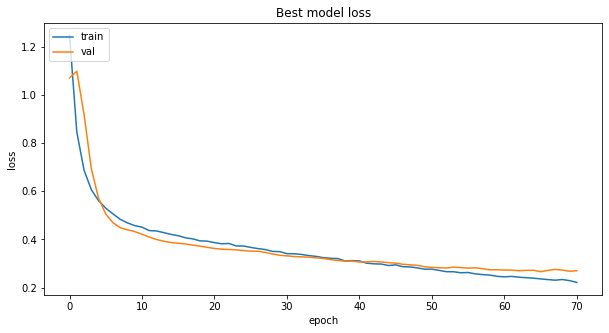

In [135]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['loss'], label='train')
plt.plot(best_model_history['val_loss'], label='val')
plt.title('Best model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.xticks(range(len(best_model_history['loss'])))
plt.legend(loc='upper left')
plt.show()

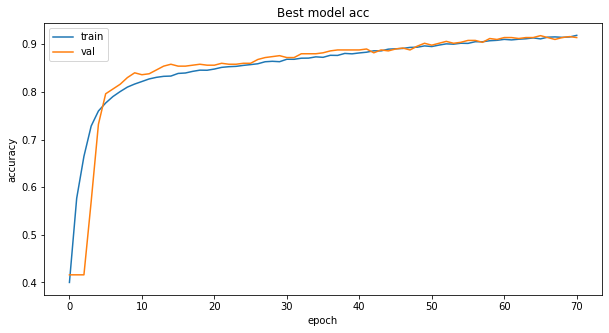

In [136]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['acc'], label='train')
plt.plot(best_model_history['val_acc'], label='val')
plt.title('Best model acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.xticks(range(len(best_model_history['acc'])))
plt.legend(loc='upper left')
plt.show()

In [137]:
def plot_embedding2D(h, color=data.y, size=100):
    h = h.detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color, s=size)
    plt.show()

# Embedding after training
embedding = torch.empty(0, dataset.num_classes).to(device)
y_test = torch.empty(0).to(device)
with torch.no_grad():
    for batch in test_loader:
        batch.to(device)
        yhat = model(batch.x, batch.edge_index)
        embedding = torch.cat((embedding, yhat))
        y_test = torch.cat((y_test, batch.y))

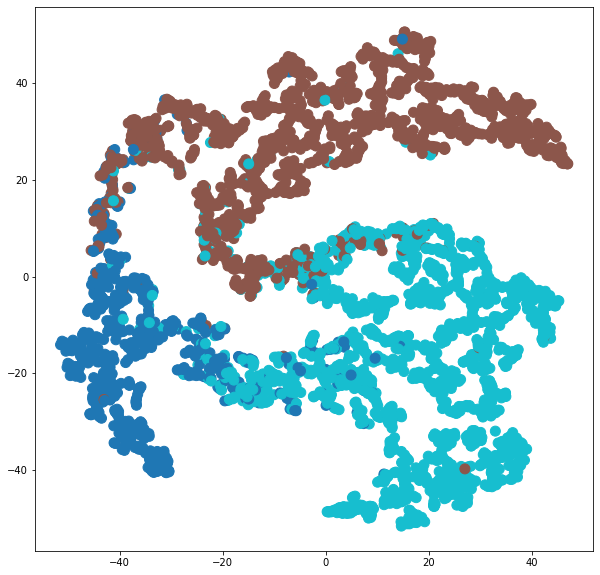

In [138]:
plot_embedding2D(embedding.cpu(), color=y_test.cpu())

#Train and evaluate ML models

In [85]:
data = dataset[0]  # Get the first graph object.

## Main ML models tuning
In this section are evaluated the performance of some ML models to see the real improvement in using a GNN model.

Also in this case a fine tuning is performed to evaluate only the best configuration of parameters for each model.

In [86]:
# X_train and X_test contains the node features
# X_train combines both train and validation splits in order to perform crossvalidation
X_train = pd.DataFrame(data.x[data.train_mask].detach().numpy())
X_train = X_train.append(pd.DataFrame(data.x[data.val_mask].detach().numpy()))
X_test = pd.DataFrame(data.x[data.test_mask].detach().numpy())
print(f'X_train\tshape: {X_train.shape}\nX_test\tshape: {X_test.shape}')

X_train	shape: (18717, 500)
X_test	shape: (1000, 500)


In [87]:
# y_train and y_test contains the node labels
y_train = data.y[data.train_mask].detach().numpy().reshape(-1,)
y_train = np.append(y_train, pd.DataFrame(data.y[data.val_mask].detach().numpy().reshape(-1,)))
y_test = data.y[data.test_mask].detach().numpy().reshape(-1,)
print(f'y_train\tshape: {y_train.shape}\ny_test\tshape: {y_test.shape}')

y_train	shape: (18717,)
y_test	shape: (1000,)


In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Labels for the models
model_lbls = [
    'lr',   # Logistic Regressor
    'rf',   # Random Forest
    'xgb',  # eXtreme Gradient Boost
]

# Set the parameters to be explored for each classifier
tuned_param_lr = [
    {
        'solver': ['lbfgs'],
    },
]
tuned_param_rf = [
    {
        'max_depth': [100],
    },
]
tuned_param_xgb = [
    {
        'objective': ['multi:softmax'],
        'tree_method': ['gpu_hist'],
    },
]

# Set the models to be fitted specifying name, estimator and parameter structure
models = {
    'lr': {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(),
        'param': tuned_param_lr,
    },
    'rf': {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(), 
        'param': tuned_param_rf,
    },
    'xgb':{
        'name': 'XGBoost',
        'estimator': XGBClassifier(),
        'param': tuned_param_xgb,
    }
}

# Scores to be explored
scores = [
    'precision', 
#    'recall',
]

In [89]:
def print_results(model):    
    print("Best parameters set found on train set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    best_score = 0
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, param in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, param))
        if mean > best_score:
          best_score = mean
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    y_pred = model.predict(X_test)
    print(f'Accuracy on test: {accuracy_score(y_test, y_pred, sample_weight=[normalized_totals_test[x] for x in y_test])*100:.2f}%')
    return best_score * 100

In [90]:
for score in scores:
    print("========================================")
    print("# Tuning hyper-parameters for {}".format(score))
    for model in models:
        print("----------------------------------------")
        print("Trying model {}".format(models.get(model)["name"]))
        start = time.time()
        clf = GridSearchCV(models.get(model)["estimator"], models.get(model)["param"], scoring='%s_macro' % score)
        clf.fit(X_train, y_train)
        print_results(clf)
        end = time.time()
        print(f"Time elapsed: {(end - start):.2f}s")

# Tuning hyper-parameters for precision
----------------------------------------
Trying model Logistic Regression
Best parameters set found on train set:

{'solver': 'lbfgs'}

Grid scores on train set:

0.863 (+/-0.006) for {'solver': 'lbfgs'}

Detailed classification report for the best parameter set:

Accuracy on test: 87.20%
Time elapsed: 20.61s
----------------------------------------
Trying model Random Forest
Best parameters set found on train set:

{'max_depth': 100}

Grid scores on train set:

0.890 (+/-0.003) for {'max_depth': 100}

Detailed classification report for the best parameter set:

Accuracy on test: 90.37%
Time elapsed: 47.55s
----------------------------------------
Trying model XGBoost
Best parameters set found on train set:

{'objective': 'multi:softmax', 'tree_method': 'gpu_hist'}

Grid scores on train set:

0.883 (+/-0.009) for {'objective': 'multi:softmax', 'tree_method': 'gpu_hist'}

Detailed classification report for the best parameter set:

Accuracy on test:

## Principal Component Analysis

Let's see what are the most relevant features of the Random Forest Classifier

In [121]:
clf = GridSearchCV(RandomForestClassifier(), tuned_param_rf, scoring='%s_macro' % score)
clf.estimator.fit(X_train, y_train)
feature_importances = pd.DataFrame(clf.estimator.feature_importances_, index = X_train.columns,  columns=['importance']).sort_values('importance', ascending=False)

In [123]:
feature_importances

,importance
0,0.065482
16,0.054162
401,0.040212
70,0.035019
184,0.028034
...,...
387,0.000310
370,0.000309
126,0.000301
312,0.000301


Let's perform standard PCA

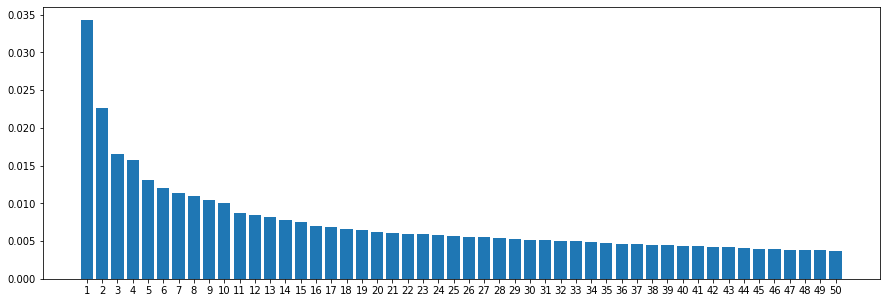

In [91]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(X_train)
n_comp = 50
pca = PCA(n_components = n_comp)
pca_vectors = pca.fit_transform(X_train)

plt.figure(figsize=(15,5))
plt.bar(range(1, n_comp+1), pca.explained_variance_ratio_)
plt.xticks(range(1, n_comp+1))
plt.show()

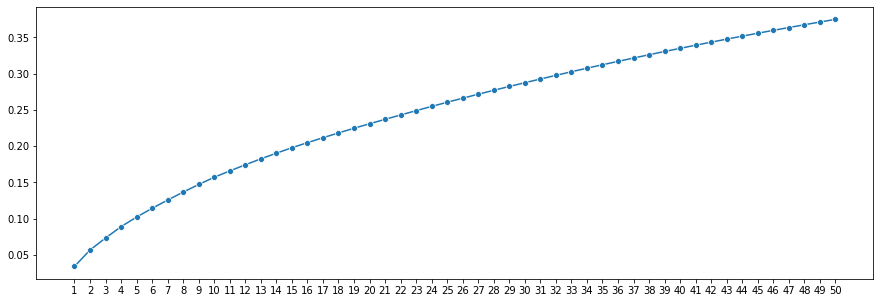

In [92]:
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

import seaborn as sns
plt.figure(figsize=(15,5))
sns.lineplot(range(1, n_comp+1), cum_explained_var, marker="o")
plt.xticks(range(1, n_comp+1))
plt.show()

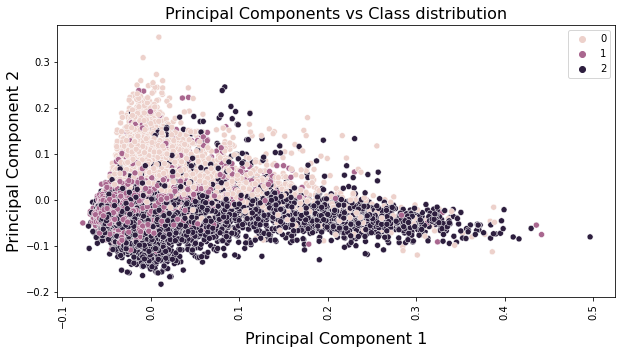

In [93]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.scatterplot(x=pca_vectors[:, 0], y=pca_vectors[:, 1], hue=y_train)
plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical');

## Label Propagation

The basic intuition of label propagation is to assign the label to a node as the label of the majority of neighbors. Intuitively it can be seen as a random walk starting from each node and stopping when arriving on a labeled node.

The matematical formulation is the following:

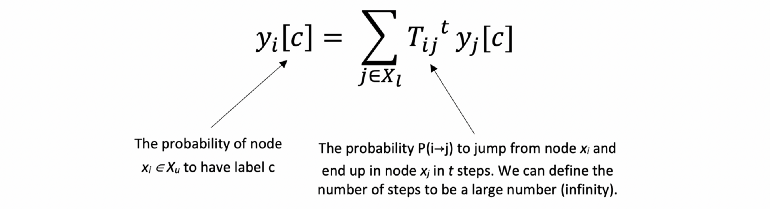

In matrix form:

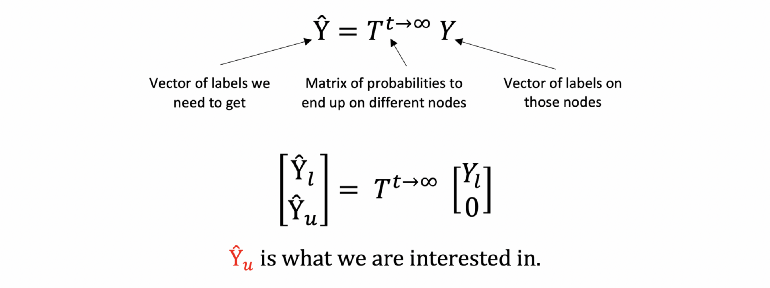

So if we can compute the probabilistic transition matrix $T$, we can compute all the label probabilities of the unlabelled nodes.

We can calculate $T$ using the degree matrix (D) and the adjacency matrix (A) as $T = D^{-1} A$.

For more details I redirect to the [source article](https://medium.com/@urbinati.cri/list/reading-list).

In [94]:
G = to_networkx(data, to_undirected=True)

A = nx.adjacency_matrix(G) 

D = np.sum(A,1)
D = np.diag(np.array(D)[:,0])
Dinv = np.linalg.inv(D)

T = Dinv*A

Y = np.zeros((data.num_nodes, dataset.num_classes)) # Create an array of zeros with size (number of nodes, number of classes)
train_mask = data.train_mask + data.val_mask        # Consider for the train both train and validation nodes
Y[train_mask, data.y[train_mask]] = 1               # Assign 1 in the index position of that class for nodes in the training set (a node with class 2 will have a mask like [0, 0, 1, ...])
Y = np.matrix(Y)

In [95]:
%%time

def LabelPropagation(T, Y, diff, max_iter, labelled):
   
    # Initialize
    Y_init = Y
    Y1 = Y
    
    # Initialize convergence parameters
    n=0
    current_diff = sys.maxsize
    
    # Iterate till difference reduces below diff or till the maximum number of iterations is reached
    while current_diff > diff and n < max_iter:
        
        current_diff = 0.0
        # Set Y(t)
        Y0 = Y1
        
        # Calculate Y(t+1)
        Y1 = T*Y0
        
        # Clamp labelled data
        for i in range(Y_init.shape[0]):
            if i in labelled:
                for j in range(Y_init.shape[1]):
                    if i!=j:
                        Y1.A[i][j] = Y_init.A[i][j]
        
        # Get difference between values of Y(t+1) and Y(t)
        for i in range(Y1.shape[0]):
            for j in range(Y1.shape[1]):
                current_diff += abs(Y1.A[i][j] - Y0.A[i][j])
        
        n += 1
        
    return Y1

L = LabelPropagation(T, Y, 0.0001, 100, [0,1,2])

CPU times: user 6min 2s, sys: 35.7 s, total: 6min 37s
Wall time: 1min 48s


In [96]:
y_pred = np.asarray(L.argmax(1)).reshape(-1,)[data.test_mask]
print(f'Accuracy on test: {accuracy_score(y_test, y_pred, sample_weight=[normalized_totals_test[x] for x in y_test])*100:.2f}%')

Accuracy on test: 72.10%
